# Инициализация

In [0]:
#@markdown - **Монтирование GoogleDrive** 
from google.colab import drive
drive.mount('GoogleDrive')

In [0]:
# #@markdown - **Размонтирование**
# !fusermount -u GoogleDrive

# Область кодов

In [0]:
#@title Распознавание лиц { display-mode: "both" }
# facial recognition
# В этой программе реализовано распознавание лиц в наборе лица FaceWarehouse
# при использовании TensorFlow для построения четырехслойных сверточных нейронных сетей
#@markdown - **Информации о наборе лица FaceWarehouse** [FaceWarehouse](http://kunzhou.net/zjugaps/facewarehouse/)
# Набор обучающих, тестовых изображений и этикетки хранятся в face_150.mat
# В программе используется батч-нормализация для решения проблемы смещения внутреннего ковариата
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import scipy.io as scio
import os,sys
from keras.utils import to_categorical

tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


In [0]:
#@markdown - **Привязка данных**
class Bunch(dict):  
	def __init__(self,*args,**kwds):  
		super(Bunch,self).__init__(*args,**kwds)  
		self.__dict__ = self
        
#@markdown - **Определение функции print_progress**
def print_progress(progress, epoch_num, loss, acc):
    """
    This function draw an active progress bar.
    :param progress: Where we are:
                       type: float
                       value: [0,1]
    :param epoch_num: number of epochs for training
    :param loss: The loss for the specific batch in training phase.

    :return: Progressing bar
    """
    
    barLength = 30

    assert type(progress) is float, "id is not a float: %r" % id
    assert 0 <= progress <= 1, "variable should be between zero and one!"

    # Символ статуса
    status = ""

    # Возврат "\ r \ n" после окончания печати
    if progress >= 1:
        progress = 1
        status = "\r\n"

    # Запись статуса
    indicator = int(round(barLength*progress))

    list = [str(epoch_num), "#"*indicator , "-"*(barLength-indicator), progress*100, loss, acc, status]
    text = "\rEpoch {0[0]} {0[1]} {0[2]} {0[3]:.2f}% completed, loss={0[4]:.4f}, acc={0[5]:.2f}%{0[6]}".format(list)
    sys.stdout.write(text)
    sys.stdout.flush()

In [0]:
#@markdown - **Определения нескольких функций**
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [0]:
#@markdown - **Настройка параметров**
num_epochs = 400 #@param {type: "integer"}
batch_size = 128 #@param {type: "integer"}
decay_steps = 200 #@param {type: "number"}
keep_p = 0.5 #@param {type: "number"}
online_test = True #@param {type: "boolean"}

data_path = 'GoogleDrive/My Drive/MATLAB/face recognition/faces_database/faces_150.mat'
# data_path = 'GoogleDrive/My Drive/MATLAB/face recognition/faces_database/faces_150_equalhis.mat'

events_path = 'GoogleDrive/My Drive/Colab Notebooks/Tensorboard'
checkpoints_path = 'GoogleDrive/My Drive/Colab Notebooks/Checkpoints'

In [0]:
#@markdown - **Считывание данных**
data = scio.loadmat(data_path)
# -------------------Выделение обучающих изображений---------------------------------------------
train_image = data['train_faces']
train_labels = to_categorical(data['train_labels'].flatten(), num_classes=150)
train_data = Bunch(train_image=train_image, train_labels=train_labels)
print('\n', 'Train image set extraction completed... ...\n')

# ----------------Выделение тестовых изображений------------------------------------------------
test_image = data['test_faces']
test_labels = to_categorical(data['test_labels'].flatten(), num_classes=150)
test_data = Bunch(test_image=test_image, test_labels=test_labels)
print(' Test image set extraction completed... ...\n')


 Train image set extraction completed... ...

 Test image set extraction completed... ...



In [0]:
#@markdown - **Создание graph**
model_name = 'model.ckpt'
graph = tf.Graph()
with graph.as_default():
    global_step = tf.Variable(0, name='global_step', trainable=False)
    # decay_steps = 100
    decay_rate = 0.8
    start_rate = 1e-3 #@param {type: "number"}
    learning_rate = tf.train.exponential_decay(start_rate,
                                                global_step=global_step,
                                                decay_steps=decay_steps,
                                                decay_rate=decay_rate,
                                                staircase=True,
                                                name='exponential_decay')
    
    with tf.name_scope('Input'):
        x = tf.placeholder("float", shape=[None, 90, 75])
        y = tf.placeholder("float", shape=[None, 150])
        keep_prob = tf.placeholder("float") # keep_prob указывает на вероятность того, что каждый нейрон активирован
        is_training = tf.placeholder(tf.bool, [])
    with tf.name_scope('Input_images'):
        x_image = tf.reshape(x, [-1, 90, 75, 1])

# --------------conv1-----------------------------------45*38*32
    with tf.name_scope('Conv1'):
        with tf.name_scope('weights_conv1'):
            W_conv1 = weight_variable([3, 3, 1, 32], name='w_conv1')
        with tf.name_scope('bias_covn1'):
            b_conv1 = bias_variable([32], name='b_conv1')

        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        with tf.name_scope('features_conv1'):
            h_pool1 = max_pool_2x2(h_conv1)
# --------------conv2-----------------------------------23*19*64
    with tf.name_scope('Conv2'):
        with tf.name_scope('weights_conv2'):
            W_conv2 = weight_variable([3, 3, 32, 64], name='w_conv2')
        with tf.name_scope('bias_covn2'):
            b_conv2 = bias_variable([64], name='b_conv2')

        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        with tf.name_scope('features_conv2'):
            h_pool2 = max_pool_2x2(h_conv2)
# --------------conv3-----------------------------------12*10*128
    with tf.name_scope('Conv3'):
        W_conv3 = weight_variable([3, 3, 64, 128], name='w_conv3')
        b_conv3 = bias_variable([128], name='b_conv3')

        h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
        h_pool3 = max_pool_2x2(h_conv3)
# --------------conv4-----------------------------------6*5*256
    with tf.name_scope('Conv4'):
        W_conv4 = weight_variable([3, 3, 128, 256], name='w_conv4')
        b_conv4 = bias_variable([256], name='b_conv4')

        h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
        h_pool4 = max_pool_2x2(h_conv4)
# --------------conv5-----------------------------------3*3*512
    with tf.name_scope('Conv5'):
        W_conv5 = weight_variable([3, 3, 256, 512], name='w_conv5')
        b_conv5 = bias_variable([512], name='b_conv5')

        h_conv5 = tf.nn.relu(conv2d(h_pool4, W_conv5) + b_conv5)
        h_pool5 = max_pool_2x2(h_conv5)

# --------------fc--------------------------------------
    with tf.name_scope('FC1'):
        h_pool5_flat = tf.layers.flatten(h_pool5, name='pool5_flatten')
        num_f = h_pool5_flat.get_shape().as_list()[-1]
        W_fc1 = weight_variable([num_f, 1024], name='w_fc1')
        b_fc1 = bias_variable([1024], name='b_fc1')
        # h_fc1 = tf.nn.relu(tf.matmul(h_pool5_flat, W_fc1) + b_fc1) # y=wx+b или y.T=(x.T)(w.T)+b.T, где у -- вектор столбца
        h_bn6 = tf.layers.batch_normalization(tf.matmul(h_pool5_flat, W_fc1) + b_fc1, training=is_training)
        h_fc1 = tf.nn.relu(h_bn6)
    with tf.name_scope('Dropout1'):
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    with tf.name_scope('FC2'):
        W_fc2 = weight_variable([1024, 1024], name='w_fc2')
        b_fc2 = bias_variable([1024], name='b_fc2')
        # h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
        h_bn7 = tf.layers.batch_normalization(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, training=is_training)
        h_fc2 = tf.nn.relu(h_bn7)
    with tf.name_scope('Dropout2'):
        h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

    with tf.name_scope('OutPut_layer'):
        W_fc3 = weight_variable([1024, 150], name='w_fc2')
        b_fc3 = bias_variable([150], name='b_fc2')
        y_conv = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
        
# ---------------------loss-----------------------------
    with tf.name_scope('Loss'):
        # y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
        # cross_entropy = -tf.reduce_mean(y * tf.log(y_conv + 1e-10)) # предотвратить log0
    # or like
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,
                                        logits=y_conv))

    with tf.name_scope('Train'):
        # Добавить update_ops в train_step
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy, global_step=global_step)
        train_step = tf.group([train_step, update_ops])

    with tf.name_scope('Accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [0]:
#@markdown - **Обучение СНС**
max_acc = 101.0 # модели с выше этой точностью будут сохранены
min_cross = 0.1
with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver(var_list=tf.global_variables(), max_to_keep=3)
    sess.run(tf.global_variables_initializer())

    print('Training ========== (。・`ω´・) ========')
    for epoch_num in range(num_epochs):
        train_s = np.c_[train_data.train_image.reshape((1500,-1)), train_data.train_labels]
        np.random.shuffle(train_s)
        max_size = train_s.shape[0] // batch_size
        for num in range(max_size):
            batch = [train_s[num*batch_size:(num+1)*batch_size, :90*75].reshape((-1,90,75)), 
                    train_s[num*batch_size:(num+1)*batch_size, -150:]]
            _, acc, loss = sess.run([train_step, accuracy, cross_entropy], 
                                    feed_dict={x: batch[0], y: batch[1], 
                                    keep_prob: keep_p, 
                                    is_training: True})

            acc *= 100
            num_iter = max_size * 10
            progress = ((epoch_num * max_size + num) % num_iter + 1) / num_iter
            num_ep = epoch_num + 1
            print_progress(progress, num_ep, loss, acc)

        if online_test and (epoch_num + 1) % 10 ==0 :
            print(' '*12, 'Online-Testing ========== (。・`ω´・) ========')
            imgs_t, labels_t = test_data.test_image.reshape((-1, 90, 75)), test_data.test_labels
            test_acc, test_loss = sess.run([accuracy, cross_entropy], feed_dict={x: imgs_t, y: labels_t,
                                                                                keep_prob: 1.0, 
                                                                                is_training: False})
            test_acc *= 100
            print(' '*10, 'Loss on testing data is %.4f, accuracy is %.2f%%.' %(test_loss, test_acc))
            print('\nKeep on training ========== (。・`ω´・) ========')

        # 3 модели с высокой точностью сохраняются
        if (loss <= min_cross) & (acc >= max_acc) & (epoch_num > 100):
            min_cross = loss
            max_acc = acc
            saver.save(sess, os.path.join(checkpoints_path, model_name), global_step=epoch_num)

    test_im, test_lab = train_data.train_image[0].reshape((-1, 90, 75)), train_data.train_labels[0].reshape((-1, 150))
    feature_map1 = sess.run(h_pool1, feed_dict={x: test_im, y: test_lab, keep_prob: 1.0, is_training: False})
    # feature_map2 = sess.run(h_pool2, feed_dict={x: test_im, y: test_lab, keep_prob: 1.0, is_training: False})

sess.close()
print('\n', 'Training completed.')

Training ========== (。・`ω´・) ========
Epoch 10 ##############################  100.00% completed, loss=0.6164, acc=79.69%
             Online-Testing ========== (。・`ω´・) ========
           Loss on testing data is 42.3186, accuracy is 2.38%.

Keep on training ========== (。・`ω´・) ========
Epoch 20 ##############################  100.00% completed, loss=0.2396, acc=92.97%
             Online-Testing ========== (。・`ω´・) ========
           Loss on testing data is 13.4297, accuracy is 11.81%.

Keep on training ========== (。・`ω´・) ========
Epoch 30 ##############################  100.00% completed, loss=0.0440, acc=98.44%
             Online-Testing ========== (。・`ω´・) ========
           Loss on testing data is 11.4219, accuracy is 13.10%.

Keep on training ========== (。・`ω´・) ========
Epoch 40 ##############################  100.00% completed, loss=0.0224, acc=100.00%
             Online-Testing ========== (。・`ω´・) ========
           Loss on testing data is 4.5120, accuracy is 30.43%.

K

In [0]:
#@markdown - **Восстановление сохраненной модели**
# with tf.Session() as sess:
    # model_path = 'Tensorboard/f_map.ckpt-241'
    # saver.restore(sess, model_path)
    # acc, loss = sess.run([accuracy, cross_entropy], feed_dict={x: test_data.test_image, 
                            # y: test_data.test_labels, keep_prob: 1.0})
    # acc_p = acc*100
    # print('Accuracy is %.2f' %(acc_p), '%.')
# sess.close()

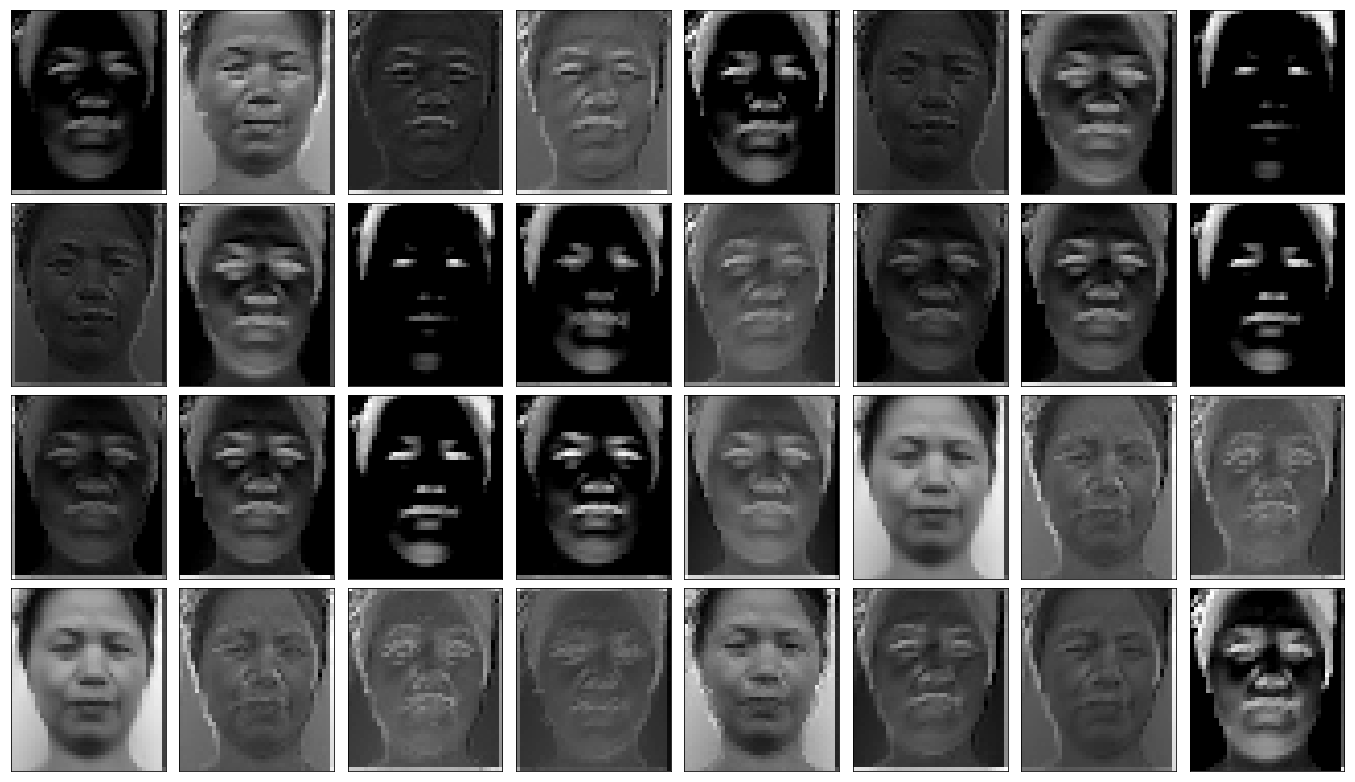

In [0]:
#@markdown - **Представление feature map первого сверточного слоя**
f_map = feature_map1.reshape((45, 38, 32))
num_map = range(f_map.shape[-1])
fig = plt.figure(1,figsize=(24, 14))
G = gridspec.GridSpec(4, 8)
G.hspace,G.wspace = .05,.05
try:
    for i in range(4):
        for j in range(8):
            plt.subplot(G[i, j])
            num = i * 5 + j
            plt.imshow(f_map[:, :, num], 'gray')
            plt.xticks([]), plt.yticks([])
except IndexError:
    plt.xticks([]), plt.yticks([])
plt.show()